## ML Challenge WS 2022/23

#### Task:

Your Task is to train a clickbait filter to classify clickbait articles by their headline. You freely decide how to prepare the data and which ML model to use for classification.

The challenge is considered passed if your model performs better than our baseline (a simple classifier; F1 ~0.89). Report at least the F1 score of your classifier. Your model will be evaluated using a hold out dataset. Please prepare a script so your trained model can be evaluated with this dataset.

#### Dataset:

The data consists of two files, a text file with clickbait headlines and one with headlines from news sources. The hold out dataset is organized the same way.

In [1]:
with open('dataset/clickbait_yes') as f:
    lines = [line.rstrip() for line in f]

lines[0:10]

['Guys Try Tinder',
 'Michael B. Jordan Got Laid The Fuck Out While Filming "Creed"',
 'What\'s The Most Fucked Up Thing You\'ve Done On "Rollercoaster Tycoon"',
 'How Far Would You Make It In The Hunger Games',
 "If Matthew Gray Gubler's Tweets Were Motivational Posters",
 "Here's What Everyone Wore To The Glamour Women Of The Year Awards",
 'How Many Of These Black Sitcoms Have You Seen',
 '17 Reasons You Should Love Eddie Redmayne',
 "Here's What Lady Gaga's Next Album Should Sound Like, According To Her Little Monsters",
 'Are These People Smiling At A Baby Or A Laptop']

#Submission for Challenge:

In [141]:
#Imports/dependencies
import numpy as np
import pandas as pd
import warnings
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [143]:
#The Warnings Filter
warnings.filterwarnings('ignore')

#Random seed value to 42.
random = 42

#To print the contents of the folder
print(os.listdir())

['challenge.ipynb', 'clickbait_hold_X.csv', 'clickbait_no', 'clickbait_yes']


In [144]:
text = [line.rstrip() for line in open(r'dataset/clickbait_yes')]
print(len(text))

14335


In [149]:
for text_no, txt in enumerate(text[:5]):
    print(text_no, txt)

0 Guys Try Tinder
1 Michael B. Jordan Got Laid The Fuck Out While Filming "Creed"
2 What's The Most Fucked Up Thing You've Done On "Rollercoaster Tycoon"
3 How Far Would You Make It In The Hunger Games
4 If Matthew Gray Gubler's Tweets Were Motivational Posters


In [150]:
#loading yes_labeled file and combining it with no label file.
clickbait_yes = pd.read_csv(r'dataset/clickbait_yes',sep='\t',names=["text", "label"])
#Clickbait YES = 1
clickbait_yes["label"] = [1]*len(clickbait_yes)
clickbait_no = pd.read_csv(r'dataset/clickbait_no',sep='\t',names=["text", "label"])
#Clickbait NO = 0
clickbait_no["label"] = [0]*len(clickbait_no)
clickbait = pd.concat([clickbait_yes, clickbait_no], axis=0)
clickbait["text"] = clickbait["text"].apply(lambda x: x.lower())
clickbait.head()

,text,label
0,guys try tinder,1
1,michael b. jordan got laid the fuck out while ...,1
2,what's the most fucked up thing you've done on...,1
3,how far would you make it in the hunger games,1
4,if matthew gray gubler's tweets were motivatio...,1


In [151]:
#Spliting into training, testing and validation.
train, test = train_test_split(clickbait, test_size=0.2, stratify=clickbait['label'], random_state=random)
train, valid = train_test_split(train, test_size=0.2, stratify=train['label'], random_state=random)

In [152]:
#We'll be validating with train + validation files.

train_val = pd.concat([train, valid])


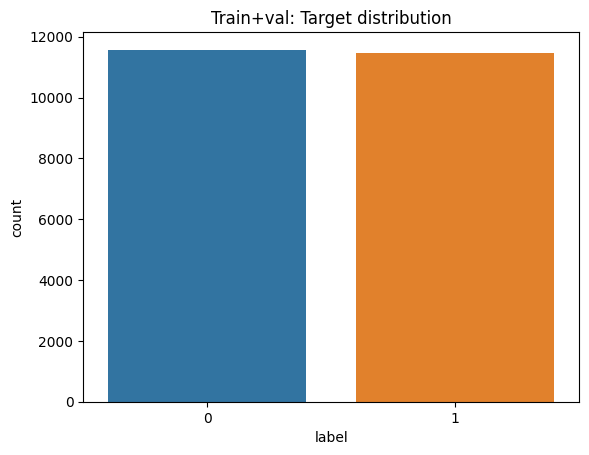

In [153]:
#Checking out the distribution of training + validation
sns.countplot(x=train_val['label']);
plt.title('Train+val: Target distribution');

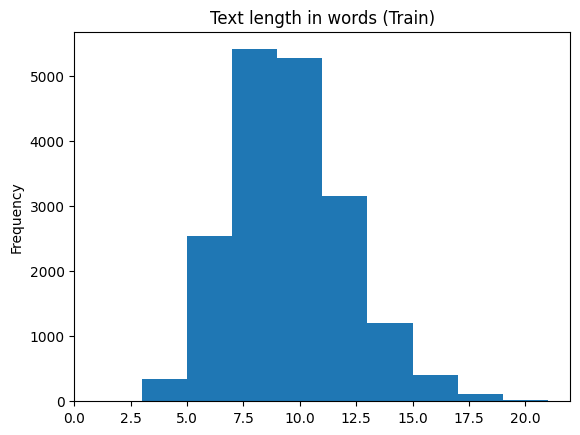

In [154]:
#Distribution of Text length in words (Train)
plt.subplots(1, 1)
plt.subplot(1, 1, 1)
train['text'].apply(lambda x: len(x.split())).plot(kind='hist')
plt.title('Text length in words (Train)')
plt.show()

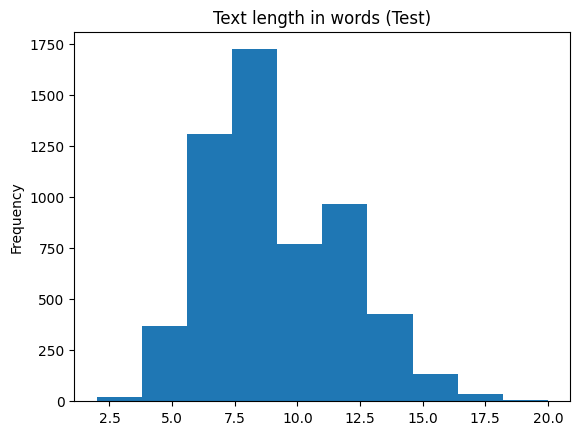

In [155]:
#Distribution of Text length in words (Testing)
plt.subplots(1, 1)
plt.subplot(1, 1, 1)
test['text'].apply(lambda x: len(x.split())).plot(kind='hist')
plt.title('Text length in words (Test)')
plt.show()

In [156]:
#Using TfidfVectorizer
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)

In [157]:
%%time
#text_transformer(TfidfVectorizer) on the training and testing.
X_train = text_transformer.fit_transform(train_val['text'])
X_test = text_transformer.transform(test['text'])

CPU times: total: 5.02 s
Wall time: 7.02 s


In [158]:
#cheking the shape of X_train and X_test
X_train.shape, X_test.shape

((23040, 110167), (5760, 110167))

In [159]:
#Parameters for Determiniation of best parameters for model.
param_grid_lr = {
    'max_iter': [15, 20, 25, 50, 100, 200, 500],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class':['auto', 'ovr', 'multinomial'],
    'C':[1,5e1],   
    'class_weight': ['None','balanced']                                    
}

In [ ]:
#Determination of best parameters for model.(Takes around 30 mins to run hence commented)

#logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=random), param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)
#logModel_grid.fit(X_train, train_val['label'])
#print(logModel_grid.best_estimator_)

In [202]:
#Creating Logistic regression Model
#logit= LogisticRegression(C=50.0, class_weight='balanced', max_iter=50,multi_class='multinomial', random_state=random, solver='sag',n_jobs=-1)

#Below model gives better resuls in less time.
logit = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial',random_state=random, n_jobs=-1)


In [203]:
#Defining KFold (split your data to K folds.)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

In [204]:
%%time
#Evaluate a score by cross-validation
cv_results = cross_val_score(logit, X_train, train_val['label'], cv=skf, scoring='f1')

CPU times: total: 359 ms
Wall time: 1min 50s


In [205]:
#Checking out the results array and also getting the mean
cv_results, cv_results.mean()

(array([0.95656009, 0.94956676, 0.95503876, 0.95581087, 0.9512358 ]),
 0.9536424572606856)

In [206]:
%%time
#Fitting LogisticRegression instance with appropriate arguments before using this estimator.
logit.fit(X_train, train_val['label'])

CPU times: total: 62.5 ms
Wall time: 20.9 s


LogisticRegression(C=50.0, multi_class='multinomial', n_jobs=-1,
                   random_state=42)

In [207]:
#Using estimator on X_test using the Fitted LogisticRegression.
test_preds = logit.predict(X_test)

In [208]:
#Prining out the confusion matrix
print(classification_report(test['label'], test_preds))
print(confusion_matrix(test['label'], test_preds))
print(accuracy_score(test['label'], test_preds))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2893
           1       0.96      0.96      0.96      2867

    accuracy                           0.96      5760
   macro avg       0.96      0.96      0.96      5760
weighted avg       0.96      0.96      0.96      5760

[[2772  121]
 [ 124 2743]]
0.9574652777777778


In [209]:
#Testing holdout dataset.
#Reading the holdout data file.
Hold_out= pd.read_csv(r'clickbait_hold_X.csv',sep='\t',names=["text", "label"])
Hold_out["text"] = Hold_out["text"].apply(lambda x: x.lower())

In [210]:
#Checking out the header of the holdout data set.
Hold_out.head()

,text,label
0,how to make the ultimate spaghetti with red sauce,NaN
1,soviet human rights activist yelena bonner die...,NaN
2,someone calculated how much money jim spent pr...,NaN
3,demonstrators clash with police in algeria aft...,NaN
4,this color quiz will tell you which husky shou...,NaN


In [211]:
#text_transformer(TfidfVectorizer) on the holdout data.
X_Hold_out = text_transformer.transform(Hold_out['text'])

In [212]:
#cheking the shape of Holdout
X_Hold_out.shape

(3200, 110167)

In [213]:
#Using estimator on X_Hold_out using the Fitted LogisticRegression.
Hold_out_preds = logit.predict(X_Hold_out)

In [214]:
#cheking the shape of Holdout after applying the  estimator
Hold_out_preds.shape

(3200,)

In [215]:
#printing out the predictions
print(Hold_out_preds)

[1 0 1 ... 0 1 1]


In [216]:
#Creating dataframes of Holdout text and predictions.
df = pd.DataFrame(Hold_out,Hold_out_preds)

In [222]:
#Combining the Text and ClickBait preditions(Labels) for the holdout dataset.
Predictions= {
    'text':Hold_out['text'],
    'label' :Hold_out_preds
          }

In [223]:
#Creating the dataframe for the Text and ClickBait preditions(Labels) for the holdout dataset.
df = pd.DataFrame(Predictions)

In [224]:
#printing the head for the prediction data frame.
#Clickbait YES = 1
#Clickbait NO = 0
df.head()

,text,label
0,how to make the ultimate spaghetti with red sauce,1
1,soviet human rights activist yelena bonner die...,0
2,someone calculated how much money jim spent pr...,1
3,demonstrators clash with police in algeria aft...,0
4,this color quiz will tell you which husky shou...,1


In [230]:
#Exporting the predictions on the holdout dataset as predictions.
df.to_csv("submission/predictions.csv",index=False,header=False)

In [231]:
#To print the contents of the folder
print(os.listdir())

['challenge.ipynb', 'clickbait_hold_X.csv', 'clickbait_no', 'clickbait_yes', 'Hold_out_predictions.csv', 'Hold_out_predictions.txt', 'requirements.txt']
